<h1 style="text-align: center;">Final Project</h1>
<h2 style="text-align: center;">02807 Computational Tools for Data Science</h2>
<p style="text-align: center;">Authors: s241645, s242689, s253167, s253095</p>

## 1. Introduction

Credit card fraud is rare, only about 0.2% of transactions in the dataset are fraudulent. This makes it difficult to train a model to recognize fraud directly, since there are so few examples to learn from.

Instead, we take an anomaly detection approach: we train a model to learn what normal transactions look like. Transactions that don't fit this learned pattern are flagged as potential fraud.

**Method:**
1. Cluster normal transactions using K-Means
2. Train a separate AutoEncoder for each cluster
3. Classify transactions with high reconstruction error as fraudulent

In [64]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    davies_bouldin_score
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## 2. Data Overview

The dataset contains credit card transactions from European cardholders in September 2013. Features V1-V28 are PCA-transformed (for privacy), while `Time` and `Amount` are original features.

In [65]:
df = pd.read_csv('../data/creditcard.csv')
print(f"Shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

fraud_count = df['Class'].sum()
normal_count = len(df) - fraud_count

print(f"Normal transactions: {normal_count} ({100 * normal_count / len(df):.2f}%)")
print(f"Fraudulent transactions: {fraud_count} ({100 * fraud_count / len(df):.2f}%)")

df.describe() # quick overview of the data

Shape: (284807, 31)
Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Normal transactions: 284315 (99.83%)
Fraudulent transactions: 492 (0.17%)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 3. Data Preprocessing

We split the data into two sets:
- **Base data**: Normal transactions only — used to train the AutoEncoders
- **Tune data**: All fraud + a sample of normal — used to find optimal thresholds and evaluate

We also standardize features using `StandardScaler` fitted only on normal data.

In [66]:
base_df = pd.read_csv('../data/base_data.csv')
tune_df = pd.read_csv('../data/tune_data.csv')

print("Base data (training):")
print(f"  {len(base_df)} samples, {base_df['Class'].sum()} fraud")

print("\nTune data (threshold tuning + evaluation):")
print(f"  {len(tune_df)} samples, {tune_df['Class'].sum()} fraud")

# Load pre-fitted scaler (fitted on normal data only)
X_base = base_df.drop(columns=['Class'])
scaler = StandardScaler()
X_base_scaled = scaler.fit_transform(X_base)

print(f"Before scaling - Mean: {X_base.values.mean():.2f}, Std: {X_base.values.std():.2f}")
print(f"After scaling  - Mean: {X_base_scaled.mean():.2f}, Std: {X_base_scaled.std():.2f}")

Base data (training):
  282347 samples, 0 fraud

Tune data (threshold tuning + evaluation):
  2460 samples, 492 fraud
Before scaling - Mean: 3164.23, Std: 19103.81
After scaling  - Mean: 0.00, Std: 1.00


## 4. Clustering
Normal transactions aren't uniform because of different spending patterns, amounts, times, etc. Rather than training one model on all data, we cluster similar transactions and train a specific AutoEncoder on each cluster.

### 4.1 K-Means Implementation
We implemented the K-Means algorithm ourselves:

In [67]:
def kmeans_implementation(X, k, max_iters=300, tol=0.0001, random_state=42) -> tuple[np.ndarray, np.ndarray]:
    """
    A simple implementation of the K-means clustering algorithm.
    Parameters:
    - X: Input data, scaled numpy array of shape (n_samples, n_features).
    - k: Number of clusters.
    - max_iters: Maximum number of iterations.
    - tol: Tolerance to declare convergence.
    - random_state: Seed for reproducibility.
    """

    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    data = np.asarray(X)
    n_samples, n_features = data.shape

    # Randomly choose initial centroids
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = data[indices, :]

    for iteration in range(max_iters):
        # Assign points to nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            points = data[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                # Reinitialize empty cluster randomly
                new_centroids[i] = data[np.random.randint(0, n_samples)]

        # Check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

class OurKmeans:
    def __init__(self, centroids: np.ndarray):
        self.centroids = centroids  # shape: (k, n_features)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Assign each row in X to the nearest centroid."""
        X = np.asarray(X)
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        return np.argmin(distances, axis=1)

### 4.2 Choosing K
We use two methods to determine the optimal number of clusters:
- **Elbow method**: Look for the "elbow" where inertia stops decreasing significantly
- **Davies-Bouldin index**: Lower values indicate better-defined clusters

Converged after 21 iterations.
Converged after 26 iterations.
Converged after 29 iterations.
Converged after 43 iterations.
Converged after 33 iterations.
Converged after 37 iterations.
Converged after 37 iterations.
Converged after 39 iterations.
Converged after 41 iterations.


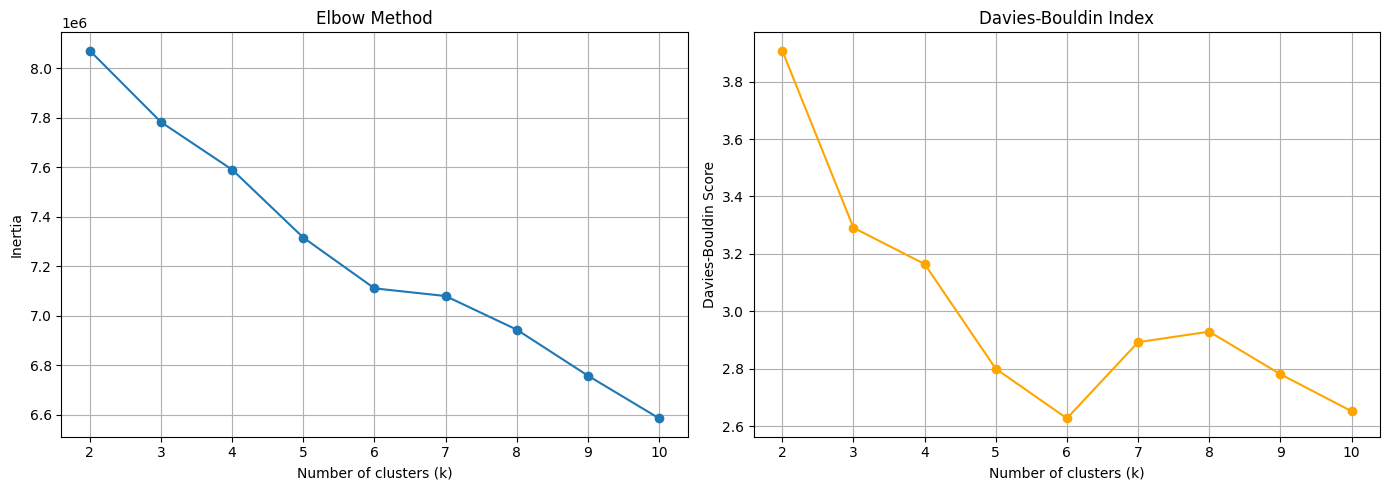

In [68]:
def compute_inertia(data, labels, centroids):
    if hasattr(data, 'to_numpy'):
        data = data.to_numpy()
    inertia = 0.0
    for i, point in enumerate(data):
        inertia += np.sum((point - centroids[labels[i]]) ** 2)
    return inertia

inertias = []
db_scores = []
k_range = range(2, 11)

for k in k_range:
    labels, centroids = kmeans_implementation(X_base_scaled, k)
    inertias.append(compute_inertia(X_base_scaled, labels, centroids))
    db_scores.append(davies_bouldin_score(X_base_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, db_scores, marker='o', color='orange')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Davies-Bouldin Index')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 4.3 Clustering Normal Transactions
With K=4 selected based on the elbow method and Davies-Bouldin index, we apply K-Means to segment the normal transactions. (kannski aðeins að henda betri rökstuðningi hingað..?)

In [69]:
K = 4
cluster_labels, centroids = kmeans_implementation(X_base_scaled, k=K, random_state=42)
kmeans = OurKmeans(centroids=centroids) # for future predictions

print("Cluster distribution:")
for i in range(K):
    count = (cluster_labels == i).sum()
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {i}: {count:,} samples ({pct:.1f}%)")

Converged after 29 iterations.
Cluster distribution:
  Cluster 0: 33,591 samples (11.9%)
  Cluster 1: 19,755 samples (7.0%)
  Cluster 2: 137,615 samples (48.7%)
  Cluster 3: 91,386 samples (32.4%)


### 4.4 Cluster Visualization

We use PCA to project the high-dimensional data into 2D and 3D for visualization....

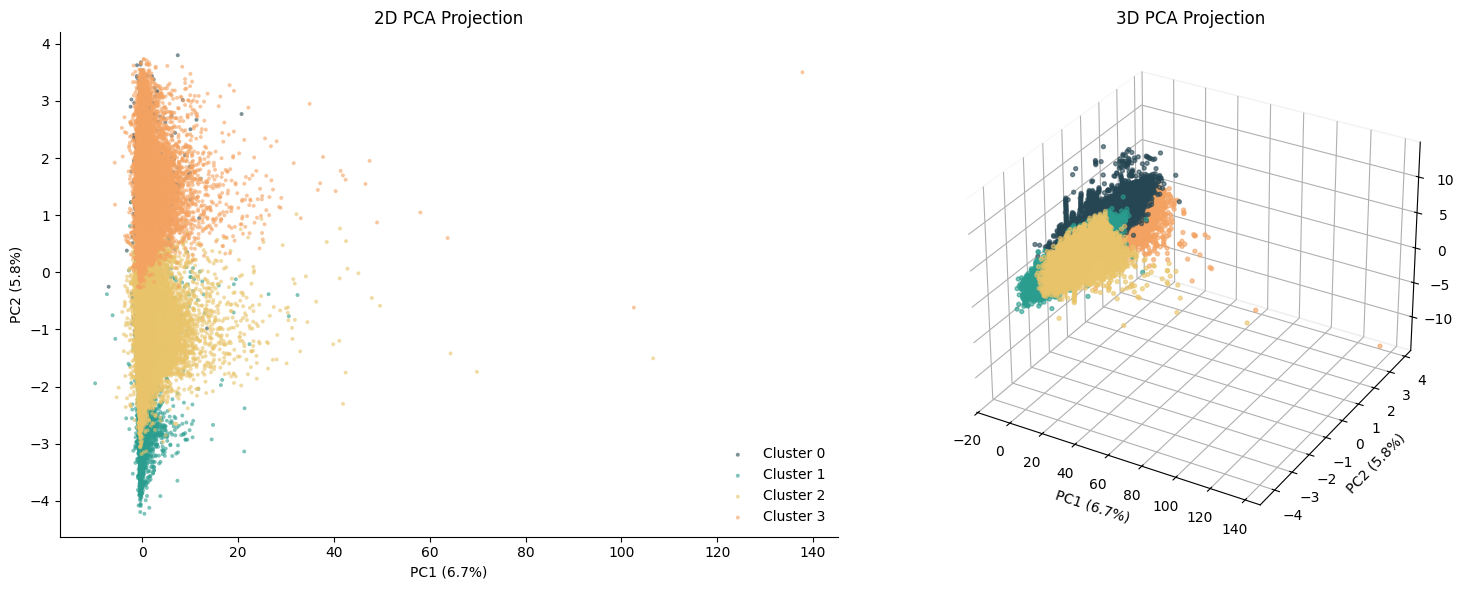

In [70]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_base_scaled)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_base_scaled)
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261']
fig = plt.figure(figsize=(16, 6))

# 2D plot
ax1 = fig.add_subplot(121)
for i in range(K):
    mask = cluster_labels == i
    ax1.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], c=colors[i], label=f'Cluster {i}', alpha=0.6, s=8, edgecolors='none')

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('2D PCA Projection')
ax1.legend(frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 3D plot
ax2 = fig.add_subplot(122, projection='3d')
for i in range(K):
    mask = cluster_labels == i
    ax2.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2], c=colors[i], label=f'Cluster {i}', alpha=0.6, s=8)

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)')
ax2.set_title('3D PCA Projection')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False

plt.tight_layout()
plt.show()

## 5. Model Architecture and Training
### 5.1 AutoEncoder
An AutoEncoder is a neural network that learns to compress its input into a small representation, then reconstruct the original input from that compressed form. The network has two parts: an encoder that compresses, and a decoder that reconstructs.

Because we train the model only on normal transactions, it learns what "normal" looks like. When we later pass a transaction through the model, we measure how well it reconstructs the input. Normal transactions are reconstructed accurately (low error), while fraudulent transactions, which the model has never seen, are reconstructed poorly (high error). This reconstruction error becomes our anomaly score.

In [71]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim=30, hidden_units=64, latent_features=2, num_layers=1):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure meaning that the decoder should be an encoder in reverse.
        
        def init_encoder_decoder(in_features, out_features, hidden_units, num_layers):
            '''
            Create an encoder / decoder with a dynamic number of layers
            '''
            layers = []

            # First layer
            layers.append(nn.Linear(in_features, hidden_units)),
            layers.append(nn.ReLU())

            for _ in range(num_layers-1):
                layers.append(nn.Linear(hidden_units, hidden_units))
                layers.append(nn.ReLU())

            # Final layer
            layers.append(nn.Linear(hidden_units, out_features))

            return nn.Sequential(*layers)

        self.encoder = init_encoder_decoder(in_dim, latent_features, hidden_units, num_layers)
        self.decoder = init_encoder_decoder(latent_features, in_dim, hidden_units, num_layers)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return {
            'z': z,
            'x_hat': x_hat
        }

### 5.2 Per-Cluster Models
Rather than training one model on all data, we train a separate AutoEncoder for each cluster. This specialization allows each model to learn the reconstruction patterns unique to its transaction type, improving anomaly sensitivity.

1. Split cluster data → 80% train, 20% validation
2. Create an AutoEncoder with the config settings
3. For each epoch:
   - Feed batches through network
   - Calculate reconstruction error (MSE)
   - Update weights to reduce error
   - Record train & validation loss
4. Return the trained model + loss history

In [72]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_on_cluster(X_cluster: np.ndarray, in_dim: int, cfg, cid: int):
    X_train, X_val = train_test_split(X_cluster, test_size=cfg["val_split"], random_state=cfg["seed"])
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val,   dtype=torch.float32)

    loader = DataLoader(TensorDataset(X_train_t), batch_size=cfg["batch_size"], shuffle=True)

    net = AutoEncoder(in_dim=in_dim, hidden_units=cfg["hidden_dim"], latent_features=cfg["latent"], num_layers=cfg["num_layers"]).to(DEVICE)
    opt = torch.optim.Adam(net.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    crit = nn.MSELoss()

    print(f"Cluster {cid}: {X_cluster.shape[0]} samples")
    train_losses, val_losses = [], []

    for epoch in range(1, cfg["epochs"] + 1):
        net.train()
        total = 0.0
        for (xb,) in loader:
            xb = xb.to(DEVICE)
            loss = crit(net(xb)["x_hat"], xb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)

        train_mse = total / len(loader.dataset)
        train_losses.append(train_mse)

        net.eval()
        with torch.no_grad():
            xv = X_val_t.to(DEVICE)
            val_mse = F.mse_loss(net(xv)["x_hat"], xv, reduction="mean").item()
        val_losses.append(val_mse)

    return net, train_losses, val_losses

### 5.4 Hyperparameter Optimization

To find the best hyperparameters for each cluster, we used Weights & Biases (wandb) sweeps. A sweep systematically searches through combinations of hyperparameters
and tracks performance.

**Hyperparameters tuned:**
- `hidden_dim`: Number of neurons in hidden layers (32, 64, 128)
- `latent`: Size of the bottleneck layer (2, 4, 8)
- `num_layers`: Depth of encoder/decoder (1, 2, 3)
- `lr`: Learning rate (1e-4 to 1e-2)
- `batch_size`: Samples per gradient update (128, 256, 512)

For each cluster, the sweep ran multiple training runs with different configurations and selected the one with the lowest validation MSE.

In [73]:
def parse_model_config(config_path):
    config = {}
    with open(config_path, 'r') as f:
        for line in f:
            if ':' in line:
                key, value = line.split(':', 1)
                key, value = key.strip(), value.strip()
                if value.isdigit():
                    value = int(value)
                else:
                    try:
                        value = float(value)
                    except ValueError:
                        pass
                config[key] = value
    return config

print("Optimal hyperparameters found via wandb sweeps:\n")
for cid in range(K):
    config = parse_model_config(f'../models/ae_cluster_{cid}/ae_cluster_{cid}_config.txt')
    print(f"Cluster {cid}:")
    print(f"  hidden_dim: {config.get('hidden_dim')}")
    print(f"  latent:     {config.get('latent')}")
    print(f"  num_layers: {config.get('num_layers')}")
    print()

Optimal hyperparameters found via wandb sweeps:

Cluster 0:
  hidden_dim: 1024
  latent:     8
  num_layers: 1

Cluster 1:
  hidden_dim: 512
  latent:     8
  num_layers: 4

Cluster 2:
  hidden_dim: 1024
  latent:     8
  num_layers: 1

Cluster 3:
  hidden_dim: 64
  latent:     8
  num_layers: 1



### 5.4 Training Demonstration
We demonstrate training on Cluster 0. For the final evaluation, we use pre-trained models.
The resulting plot shows how the MSE decreases by each epoch as the model becomes better at constructing the transactions.

Cluster 0: 33591 samples


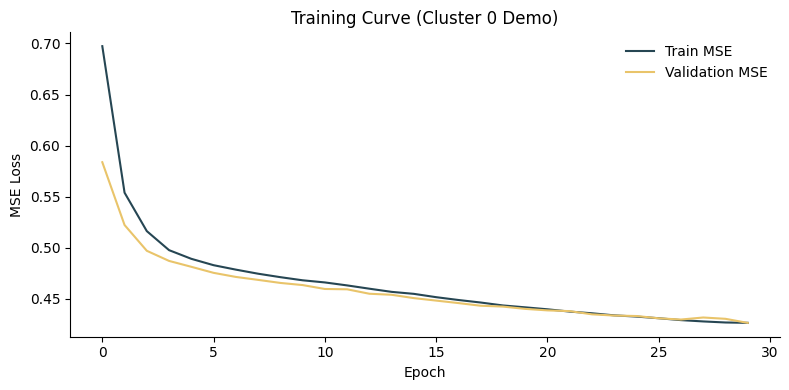

In [74]:
demo_cfg = {
    "val_split": 0.2,
    "seed": 42,
    "batch_size": 256,
    "hidden_dim": 64,
    "latent": 2,
    "num_layers": 1,
    "lr": 1e-3,
    "weight_decay": 0,
    "epochs": 30
}

X_cluster_0 = X_base_scaled[cluster_labels == 0]
demo_model, train_losses, val_losses = train_on_cluster(X_cluster_0, in_dim=30, cfg=demo_cfg, cid=0)

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train MSE', color='#264653')
plt.plot(val_losses, label='Validation MSE', color='#e9c46a')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Curve (Cluster 0 Demo)')
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## 6. Threshold Tuning and Evaluation
### 6.1 Loading Pretrained Models
We load AutoEncoders that were trained with optimized hyperparameters for each cluster.

In [75]:
def load_pretrained_model(cluster_id, models_dir='../models'):
    base_path = f'{models_dir}/ae_cluster_{cluster_id}'
    config = parse_model_config(f'{base_path}/ae_cluster_{cluster_id}_config.txt')

    model = AutoEncoder(
        in_dim=30,
        hidden_units=config['hidden_dim'],
        latent_features=config['latent'],
        num_layers=config['num_layers']
    )
    model.load_state_dict(torch.load(f'{base_path}/ae_cluster_{cluster_id}.pt', map_location='cpu', weights_only=True))
    model.eval()
    return model

models = {i: load_pretrained_model(i) for i in range(K)}

### 6.2 Threshold Tuning
To avoid data leakage, we split the tune data into two parts:
- **Tune set (50%)**: Used to find optimal thresholds
- **Test set (50%)**: Used for final evaluation

For each cluster, we find the threshold that maximizes F1 score on the tune set since F1 balances precision and recall.

In [76]:
def compute_reconstruction_errors(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        reconstructed = model(X_tensor)['x_hat']
        errors = F.mse_loss(reconstructed, X_tensor, reduction='none').mean(dim=1)
    return errors.cpu().numpy()

def find_optimal_threshold(errors, y_true, n_thresholds=200):
    thresholds = np.linspace(errors.min(), errors.max(), n_thresholds)
    best_f1, best_threshold = 0, 0
    all_results = []

    for threshold in thresholds:
        preds = (errors > threshold).astype(int)
        tp = ((preds == 1) & (y_true == 1)).sum()
        fp = ((preds == 1) & (y_true == 0)).sum()
        fn = ((preds == 0) & (y_true == 1)).sum()

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        all_results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold

    return best_threshold, best_f1, pd.DataFrame(all_results)

# Prepare tune data
X_tune_all = tune_df.drop(columns=['Class']).values
y_tune_all = tune_df['Class'].values
X_tune_scaled = scaler.transform(X_tune_all)

# Split into tune/test
X_tune, X_test, y_tune, y_test = train_test_split(
    X_tune_scaled, y_tune_all, test_size=0.5, random_state=42, stratify=y_tune_all
)

tune_clusters = kmeans.predict(X_tune)
test_clusters = kmeans.predict(X_test)

# Compute errors and find thresholds for each cluster
cluster_data_tune = {}
optimal_thresholds = []
threshold_results = {}

for cid in range(K):
    mask = tune_clusters == cid
    X_cluster = X_tune[mask]
    y_cluster = y_tune[mask]

    errors = compute_reconstruction_errors(models[cid], X_cluster)
    cluster_data_tune[cid] = {'errors': errors, 'labels': y_cluster}

    thresh, f1, results_df = find_optimal_threshold(errors, y_cluster)
    optimal_thresholds.append(thresh)
    threshold_results[cid] = results_df

    print(f"Cluster {cid}: threshold = {thresh:.4f}, F1 = {f1:.4f}")

Cluster 0: threshold = 0.3039, F1 = 0.8539
Cluster 1: threshold = 0.9604, F1 = 0.9231
Cluster 2: threshold = 3.9564, F1 = 0.8795
Cluster 3: threshold = 1.2800, F1 = 0.9247


/Users/sunna/Desktop/dtu/year2/autumn/Data Science/project/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 6.3 Threshold vs Performance (ekki nauðsynlegt, bara uppá gröfin)
These plots show how precision, recall, and F1 change as we vary the threshold for each cluster.

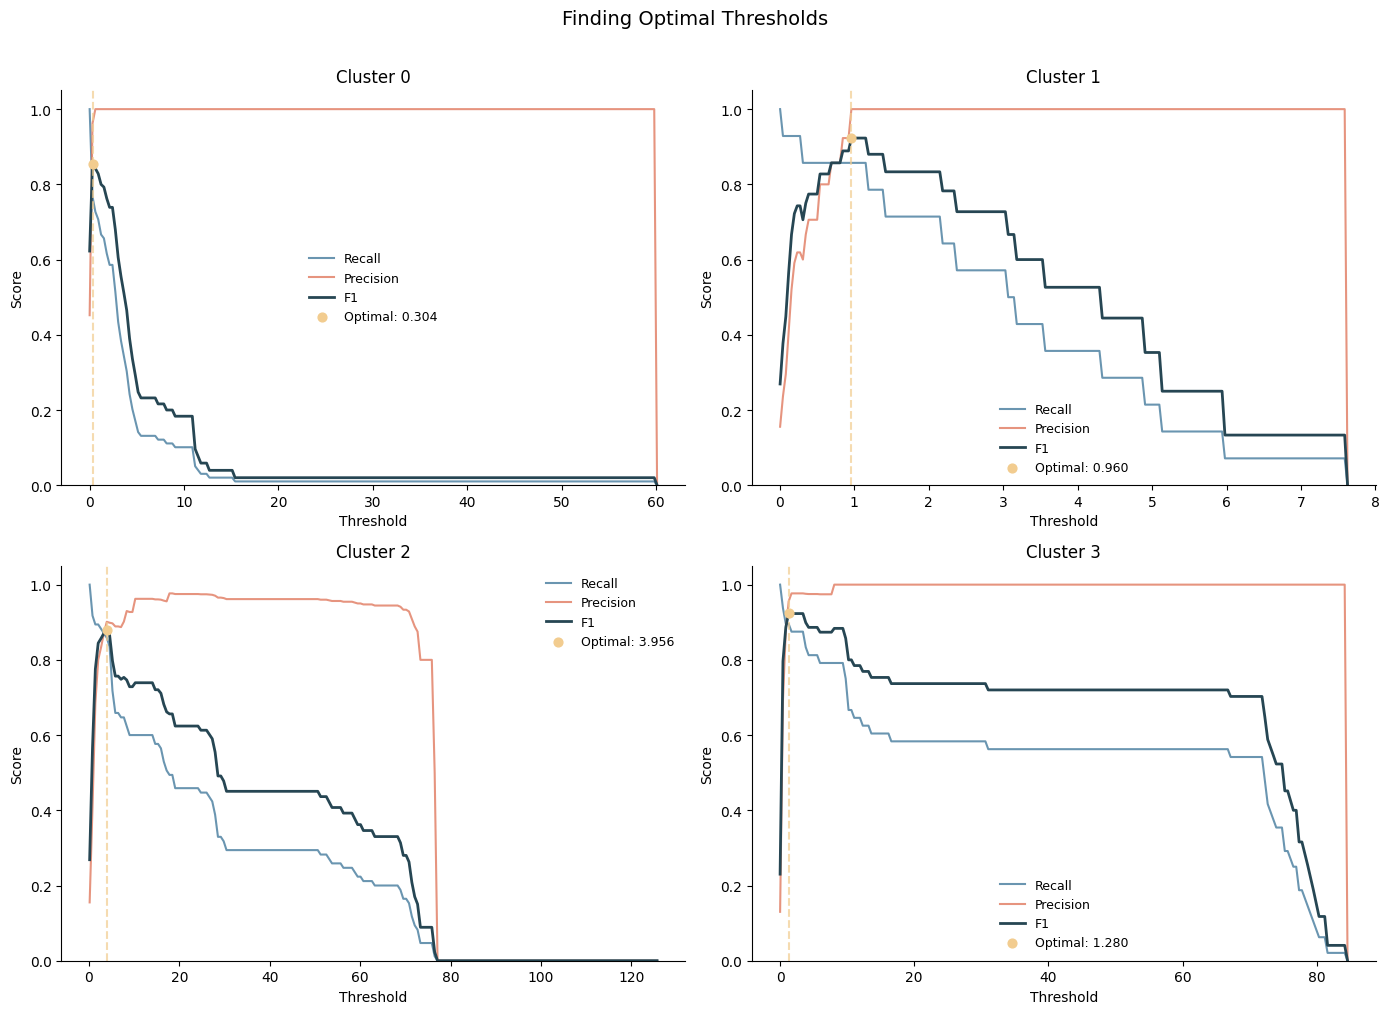

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = {'recall': '#457b9d', 'precision': '#e07a5f', 'f1': '#264653', 'optimal': '#f2cc8f'}

for cid, ax in enumerate(axes.flatten()):
    results_df = threshold_results[cid]

    ax.plot(results_df['threshold'], results_df['recall'], label='Recall', color=colors['recall'], linewidth=1.5, alpha=0.8)
    ax.plot(results_df['threshold'], results_df['precision'], label='Precision', color=colors['precision'], linewidth=1.5, alpha=0.8)
    ax.plot(results_df['threshold'], results_df['f1'], label='F1', color=colors['f1'], linewidth=2)

    best_thresh = optimal_thresholds[cid]
    best_f1 = results_df.loc[results_df['f1'].idxmax(), 'f1']
    ax.axvline(best_thresh, color=colors['optimal'], linestyle='--', linewidth=1.5, alpha=0.7)
    ax.scatter([best_thresh], [best_f1], color=colors['optimal'], s=40, zorder=5, label=f'Optimal: {best_thresh:.3f}')

    ax.set_title(f'Cluster {cid}', fontsize=12)
    ax.set_xlabel('Threshold', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1.05])
    ax.legend(loc='best', frameon=False, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Finding Optimal Thresholds', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 6.4 Final Evaluation
We apply the tuned thresholds to the untouched test set.

In [79]:
cluster_data_test = {}
y_pred_test = np.zeros_like(y_test)

for cid in range(K):
    mask = test_clusters == cid
    X_cluster = X_test[mask]
    y_cluster = y_test[mask]

    errors = compute_reconstruction_errors(models[cid], X_cluster)
    cluster_data_test[cid] = {'errors': errors, 'labels': y_cluster, 'mask': mask}

    preds = (errors > optimal_thresholds[cid]).astype(int)
    y_pred_test[mask] = preds

    f1 = f1_score(y_cluster, preds, zero_division=0)
    print(f"Cluster {cid}: F1 = {f1:.4f}")

# Overall metrics
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f"\nOverall Test Set Results:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1 Score:  {f1:.4f}")

Cluster 0: F1 = 0.8333
Cluster 1: F1 = 0.8800
Cluster 2: F1 = 0.8734
Cluster 3: F1 = 0.8831

Overall Test Set Results:
  Accuracy:  0.9455
  Precision: 0.8874
  Recall:    0.8333
  F1 Score:  0.8595


### 6.5 Confusion Matrix (ekki nauðsynlegt heldur en kannski fyrir reportið?)

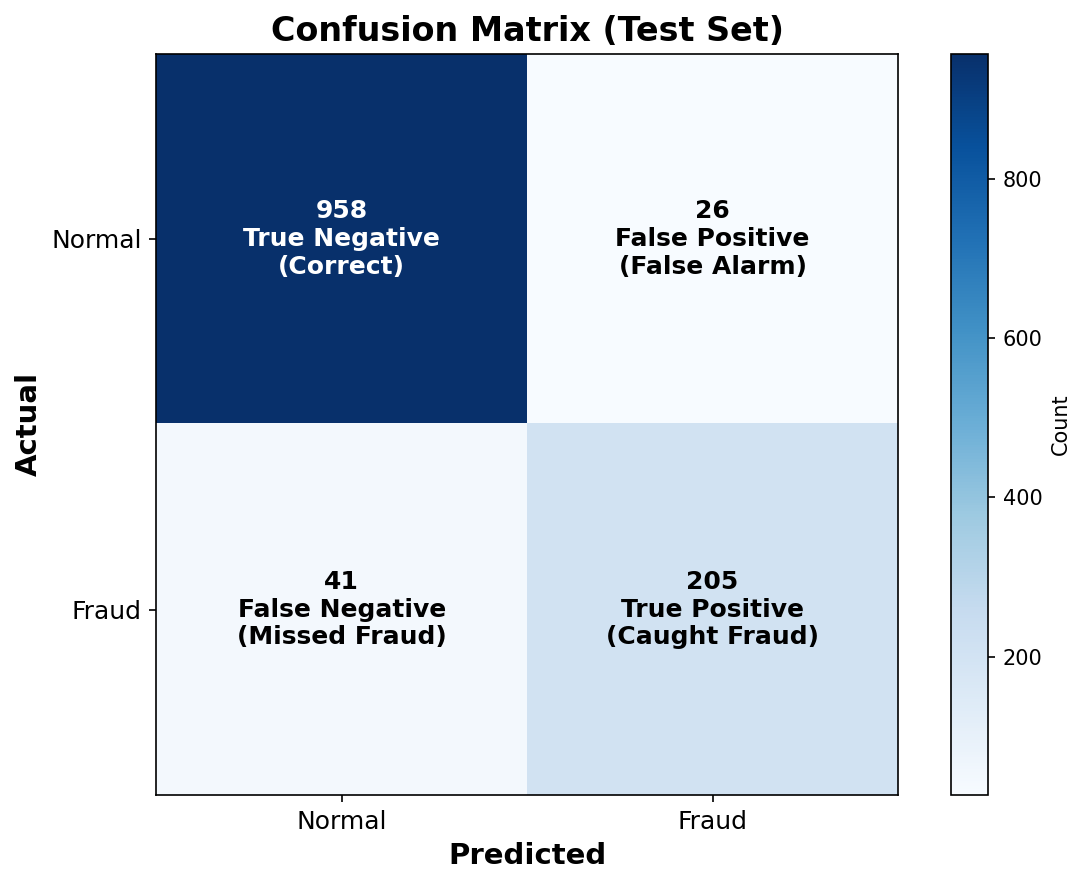

In [93]:
cm = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
im = ax.imshow(cm, cmap='Blues')

labels = [['True Negative\n(Correct)', 'False Positive\n(False Alarm)'],
        ['False Negative\n(Missed Fraud)', 'True Positive\n(Caught Fraud)']]

for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        ax.text(j, i, f'{cm[i, j]}\n{labels[i][j]}', ha='center', va='center', fontsize=12, color=color, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_yticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_xlabel('Predicted', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')

plt.colorbar(im, ax=ax, label='Count')
plt.tight_layout()
plt.show()